In [1]:
using OMJulia, Plots, CSV, DataFrames

In [ ]:
# OpenModelicaファイルのPATHの指定
model_name = "C:/work/test/BottleCooling1DCAE/CoolingBottle.mo"
CoolingBottle = OMJulia.OMCSession() 
CoolingBottle.ModelicaSystem(model_name,"CoolingBottle")


In [ ]:
params = CSV.read("CoolingBottleParameters.csv", DataFrame)

,条件名,初期ミルク温度 [K],初期ボトル温度 [K],冷却水温度 [K],熱伝達係数*面積 [W/K]
,String,Float64,Float64,Float64,Float64
1,ガラス哺乳瓶,363.15,363.15,288.15,67.4
2,プラスチック哺乳瓶,363.15,363.15,288.15,17.9


In [ ]:
# 条件数を取得
num_rows = nrow(params)

# 初期値リスト
t0_milk_list = [params[i, :2] for i in 1:num_rows]
t0_bottle_list = [params[i, :3] for i in 1:num_rows]
t_water_list = [params[i, :4] for i in 1:num_rows]

# モデルパラメータリスト
h_interface_list = [params[i, :5] for i in 1:num_rows]
g_bottle_list = [params[i, :6] for i in 1:num_rows]
hc_milk_list = [params[i, :7] for i in 1:num_rows]
hc_bottle_list = [params[i, :8] for i in 1:num_rows]

2-element Vector{Float64}:
 75.4
 75.4

In [ ]:
# 計算時間の設定
time_start = 0.0 # [s]
time_stop = 10.0 * 60 # [s]

# 計算時の時間刻み
dt = 1.0 # [s]
step_size = dt

CoolingBottle.setSimulationOptions([
    "startTime=$time_start",
    "stopTime=$time_stop",
    "stepSize=$step_size"
])


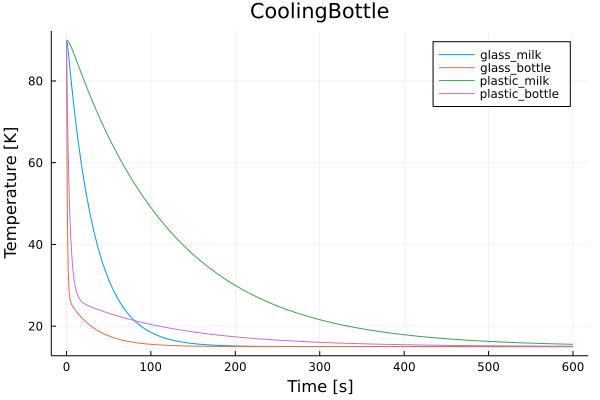

In [ ]:
output_labels = [
    "time",
    "T_milk",
    "T_bottle",
]

# 空のDataFrameを作成
df = DataFrame()

for i in 1:num_rows
    # 初期値をリストから取得
    t0_milk = t0_milk_list[i]
    t0_bottle = t0_bottle_list[i]
    t_water = t_water_list[i]
    
    # モデルパラメータをリストから取得
    h_interface = h_interface_list[i]
    g_bottle = g_bottle_list[i]
    hc_milk = hc_milk_list[i]
    hc_bottle = hc_bottle_list[i]

    # モデルパラメータ変更
    CoolingBottle.setParameters([
        "T0Milk=$t0_milk",
        "T0Bottle=$t0_bottle",
        "TWater=$t_water",
        "HInterface=$h_interface",
        "GBottle=$g_bottle",
        "HCMilk=$hc_milk",
        "HCBottle=$hc_bottle",
    ])
    
    # Simulation実行
    CoolingBottle.simulate()
    
    # 結果取得
    time,t_milk,t_bottle = CoolingBottle.getSolutions(output_labels)
    # 要素数を取得
    rows = size(time)[1]
    # Kを℃に変換する処理
    conversion_list = [-273.15 for t in 1:rows]
    t_milk_c = t_milk + conversion_list
    t_bottle_c = t_bottle + conversion_list

    # 1条件目の結果をDataFrameに格納
    if i < 2
        df.Time = time
        df[:,2] = t_milk_c
        df[:,3] = t_bottle_c

    # 2条件目の結果をDataFrameに格納
    # @TODO 3条件目以降があるときに汎用性を持たせるように修正
    else
        df[:,4] = t_milk_c
        df[:,5] = t_bottle_c
    end

end
# グラフ描画
plot(df.Time, [df[:,2], df[:,3], df[:4], df[:5]], label=["glass_milk" "glass_bottle" "plastic_milk" "plastic_bottle"])
xlabel!("Time [s]")
ylabel!("Temperature [℃]")
title!("CoolingBottle")